In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
from datasets import Datasets
import numpy.linalg as linalg
import seaborn as sn
import pandas as pd

# K-means

In [2]:
from kmeans import Kmeans

In [3]:
#Create data points
Npts_imb = 220
Nclusters = 2
np.random.seed(7)
data_coordinates = np.random.normal(loc = 0.0, scale = 1.0, size = (Npts_imb, 2))

#Assign randomly each datapoint to a cluster
labels = np.random.choice(list(range(Nclusters)),
                          size = Npts_imb,
                          replace = True,
                          p = [0.15, 0.85])

#Assign each cluster a mean.
data_means = np.zeros((2,2))
data_means[0,] = [6, 5]
data_means[1,] = [11, 6]
#Shift the points towards the mean
data =data_coordinates + data_means[labels, ]

In [4]:
km = Kmeans(K = 2, eps = 1e-10, seed=123)
km.fit_kmeans(data)

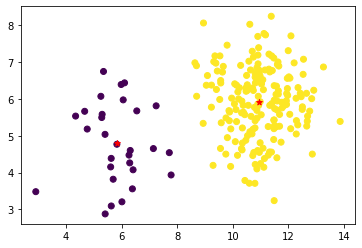

In [5]:
plt.scatter(data[:,0], data[:,1], c = km.labels)
plt.scatter(km.centroids[:,0], km.centroids[:,1], marker = '*', c = "red")
plt.show()

# PCA

In [6]:
from pca import pca

In [7]:
from keras.datasets import mnist
((x_train, y_train),  (x_test, y_test)) = mnist.load_data()

In [8]:
standard_xtest = pca.standardize_images_channel_wise(x_test, 1e-10)

In [9]:
pca_mnist = pca(M=2)
pca_mnist.fit_pca(standard_xtest)

In [10]:
new_coordinates = np.vstack((pca_mnist.new_coordinates, y_test)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))


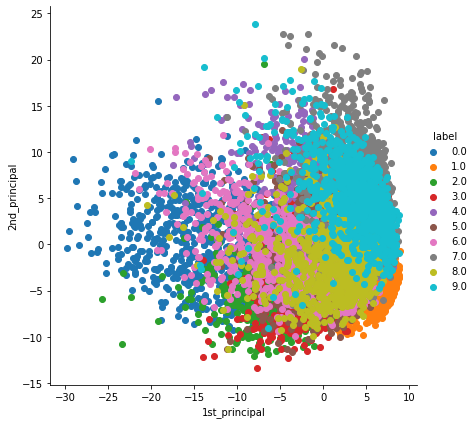

In [11]:
sn.FacetGrid(dataframe, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

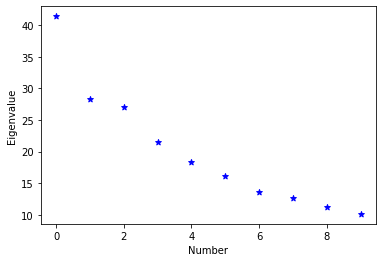

In [44]:
plt.scatter(list(range(10)), pca_mnist.[0:10],c="blue", marker = "*")
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')
plt.show()

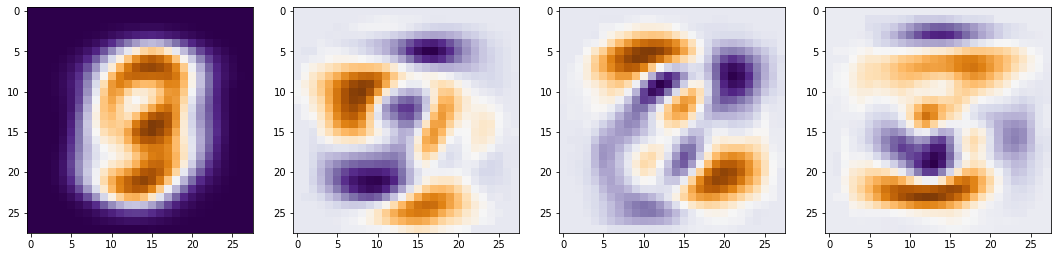

In [46]:
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(np.reshape(x_test,(-1, H * W)).mean(axis=0).reshape(28,28), cmap="PuOr_r")
for i in range(1,4):
    plt.subplot(1, 4, i+1)
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.imshow(eigenVectors[:,i].reshape(28,28), cmap="PuOr_r")

plt.show()


In [52]:
M = 2
new_coordinates = np.dot(eigenVectors[:,0:M].T, standard_xtest.T)
eigenval_new_coordinates = eigenValues[0:M]

In [76]:
pca_mnist.new_coordinates.shape

(2, 10000)

In [77]:
y_test.shape

(10000,)

In [78]:
new_coordinates = np.vstack((pca_mnist.new_coordinates, y_test)).T

In [ ]:
new_coordinates

In [79]:
new_coordinates = np.vstack((pca_mnist.new_coordinates, y_test)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))

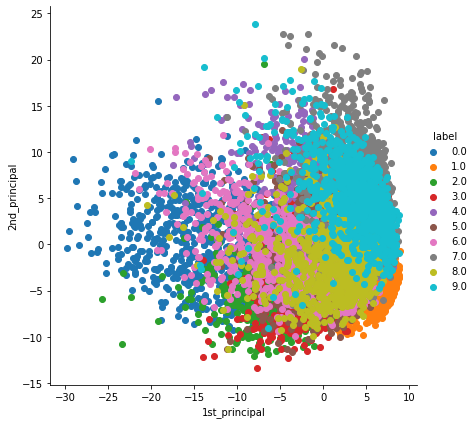